# 基于机器学习的房价预测模型

In [1]:
# 导入需要的模块
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 用来绘图的，封装了matplot
# 要注意的是一旦导入了seaborn，
# matplotlib的默认作图风格就会被覆盖成seaborn的格式
import seaborn as sns       

from scipy import stats
from scipy.stats import  norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  
# 为了在jupyter notebook里作图，需要用到这个命令

In [2]:
data_train = pd.read_csv("train.csv")

In [3]:
data_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# 二、观察各项主要特征与房屋售价的关系

为了能更好的判断各项特征对“房价”的关系，我们需要花上一点时间来对数据进行研究和处理。虽然比较耗时和费事，但是这会让我们后面构建模型的时候事半功倍。

## 1. 分析“SalePrice”

In [4]:
data_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

通过上面的结果可以知道“SalePrice”没有无效或者其他非数值的数据，下面通过图示化来进一步展示“SalePrice”

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

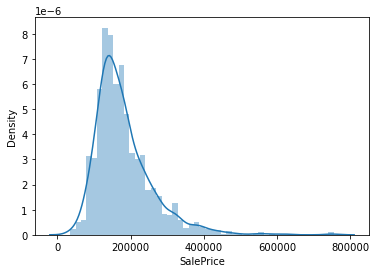

In [5]:
sns.distplot(data_train['SalePrice'])

可以看到与使用matplotlib作的直方图最大的区别在于有一条密度曲线（KDE），可以通过设置参数去掉这条默认的曲线。
另外由上图可以知道房价呈现**正态分布**。下面还可以看到两个统计学中的概念：
**峰度（Kurtosis）**和 **偏度（Skewness）**。

> **峰度：峰度（Kurtosis）是描述某变量所有取值分布形态陡缓程度的统计量。**

>它是和正态分布相比较的。

> - Kurtosis=0 与正态分布的陡缓程度相同。

> - Kurtosis>0 比正态分布的高峰更加陡峭——尖顶峰

> - Kurtosis<0 比正态分布的高峰来得平台——平顶峰计算公式：**β = M_4 /σ^4** 偏度：


> **偏度：偏度（Skewness）是描述某变量取值分布对称性的统计量。**

> - Skewness=0 分布形态与正态分布偏度相同
> - Skewness>0 正偏差数值较大，为正偏或右偏。长尾巴拖在右边。
> - Skewness<0 负偏差数值较大，为负偏或左偏。长尾巴拖在左边。 计算公式：
S= (X^ - M_0)/δ Skewness 越大，分布形态偏移程度越大。

In [6]:
#skewness and kurtosis
print("Skewness: %f" % data_train['SalePrice'].skew())
print("Kurtosis: %f" % data_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


将上面的计算结果、理论和图形相对比可以看到，长尾巴确实拖在右边，而且高峰陡峭。

## 2. 分析特征数据

### 2.1 数据再分类
为了让我们对数据的分析更具科学性，我们可以新建一个excel文件，具体需要记录的数据如下：

- **Variable**：变量名
- **Data Type**：各变量的数据类型，分为“数值型--0”和“类别型--1”
- **Segment**：变量的类型。分为：“building--0”、“space--1”、“location--2”。具体解释如下：
    - **building**：比如房屋材料、造型等与房屋物理特性相关的特征（e.g. 'OverallQual'）
    - **space**：即与房屋空间有关的特征，如面积(e.g. 'TotalBsmtSF')
    - **location**：如地段、道路情况等(e.g. 'Neighborhood')
- **Expectation**：表示我们认为该变量对于“SalePrice”的影响程度，划分为“High---3”，“Medium---2”，“Low---1”
- **Conclusion**：与“Expectation”类似，这个表示我们在观察完数据后得出的结论，其实也可和“Expectation”相同。
- **Comments**：其他关于该变量的一些看法

### 2.2 提取主要特征
接下来要做的就是按照上面要求完成电子表单

下面将会对整理后的数据进一步分析来选出主要影响售价的特征。
- **Utilities**：第一个映入我眼帘的是**Utilities**，因为公共设施越齐全肯定越贵嘛，但是我又观察了具体的训练数据集，发现每一个房屋都是“AllPub”，即都具备基础的公共设施，所以这一项不能入选。
- **LotArea**：“**地皮面积**”，面积越大肯定越贵。。。
- **Neighborhood**：这应表示房屋所处市区的位置。
- **OverallQual**：对房子的整体材料和装修进行评估
- **YearBuilt**：建造年份
- **TotalBsmtSF**&**GrLivArea**：训练数据中有很多特征都涉及到了面积，所以没必要每个都考虑进去，为了简化，选择了**TotalBsmtSF（地下室面积）**&**GrLivArea（生活面积）**
- **Heating**：供暖方式应该很重要，但是数据显示基本上都是**GasA**类型，所以不予考虑，
- **CentralAir**：中央空调这个可以考虑一下，因为有的有，有的没有。
- **MiscVal**: 在其他类别中未涉及的其他功能的价值，一般都是“shed（棚子）”，价格在400-1500美元之间，可以考虑一下
- **GarageCars**&**GarageArea**：车库可容纳的车辆数以及其面积，这个可以算成单位车辆拥有的面积来计算

总结起来入选的特征如下：

|Variable|Segment|Data Type|Comments|
|-------|--------|--------|---------|
|**LotArea**| 1 | 0  | 地皮面积|
|**GrLivArea**   | 1  |  0 |生活面积|
|**TotalBsmtSF**   | 1  |  0 |地下室总面积|
|**MiscVal**   | 0  | 0  |其他资产|
|**GarageArea**/**GarageCars** | 1  |  0 |车库|
|**YearBuilt**   | 0  | 1  | 建造年份|
|**CentralAir**   | 0  |  1 |中央空调|
|**OverallQual**   | 0  | 1  |总体评价|
|**Neighborhood**  |  2 |  1 |地段|

如上表所示，入选5个数值型特征，4个分类型特征

## 3.验证主要特征是否满足要求

### 3.1 类别型特征
#### 1. CentralAir 中央空调

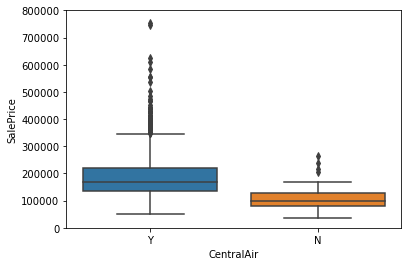

In [7]:
# CentralAir
var = 'CentralAir'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

可以很明显的看到有中央空调的房价明显更高。
#### 2. OverallQual 总体评价

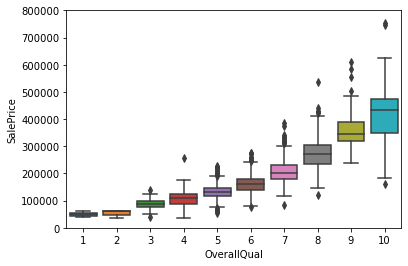

In [8]:
# OverallQual
var = 'OverallQual'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

#### 3. YearBuilt 建造年份

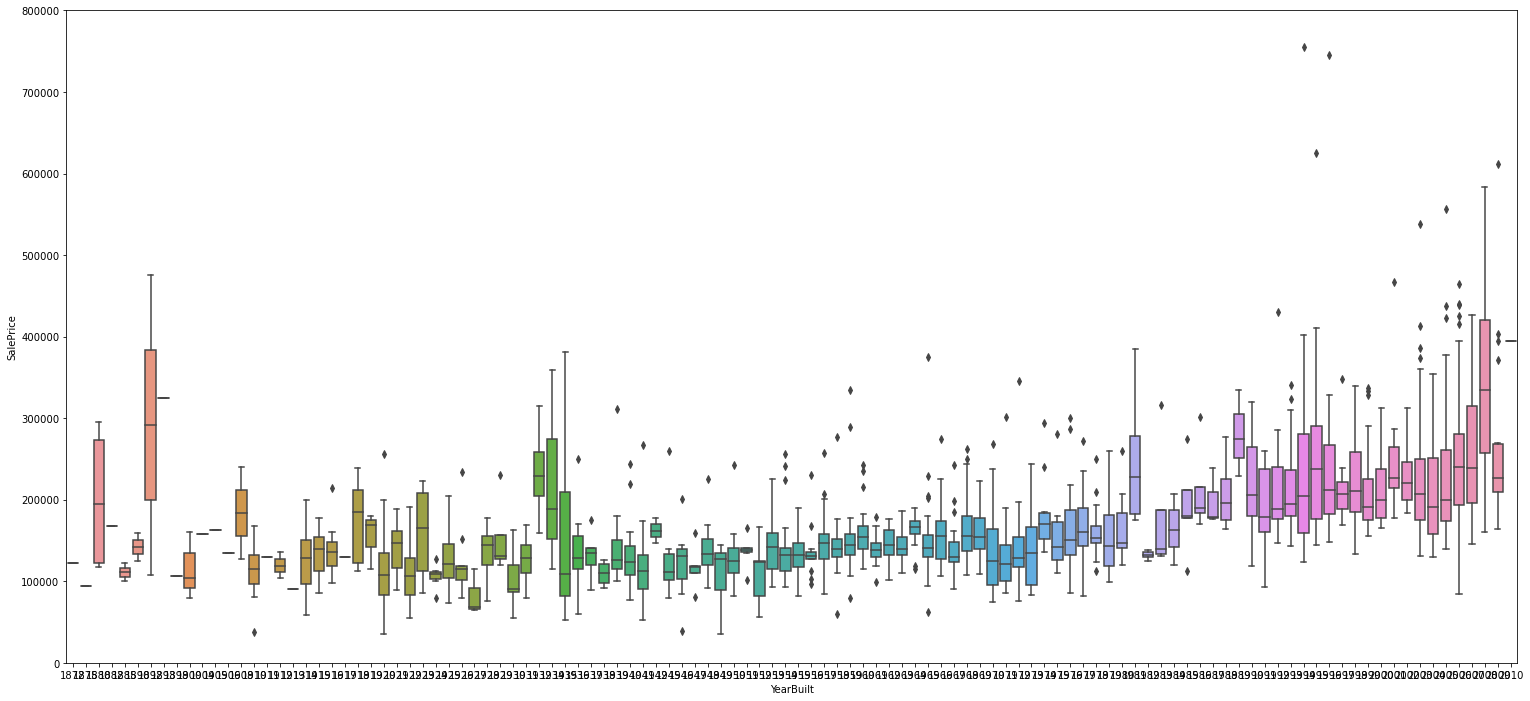

In [9]:
# YearBuilt boxplot
var = 'YearBuilt'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

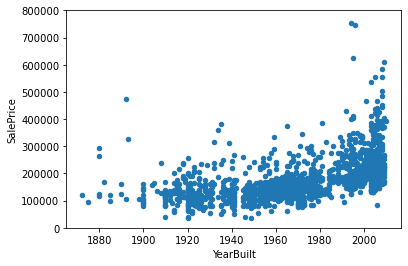

In [10]:
# YearBuilt  scatter
var = 'YearBuilt'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

最开始我是用了箱线图绘制了房价与建造年份的关系，但是并不十分明显，所以又用点图来显示，可以很明显的看到有线性增长的趋势。

#### 4. Neighborhood 地段

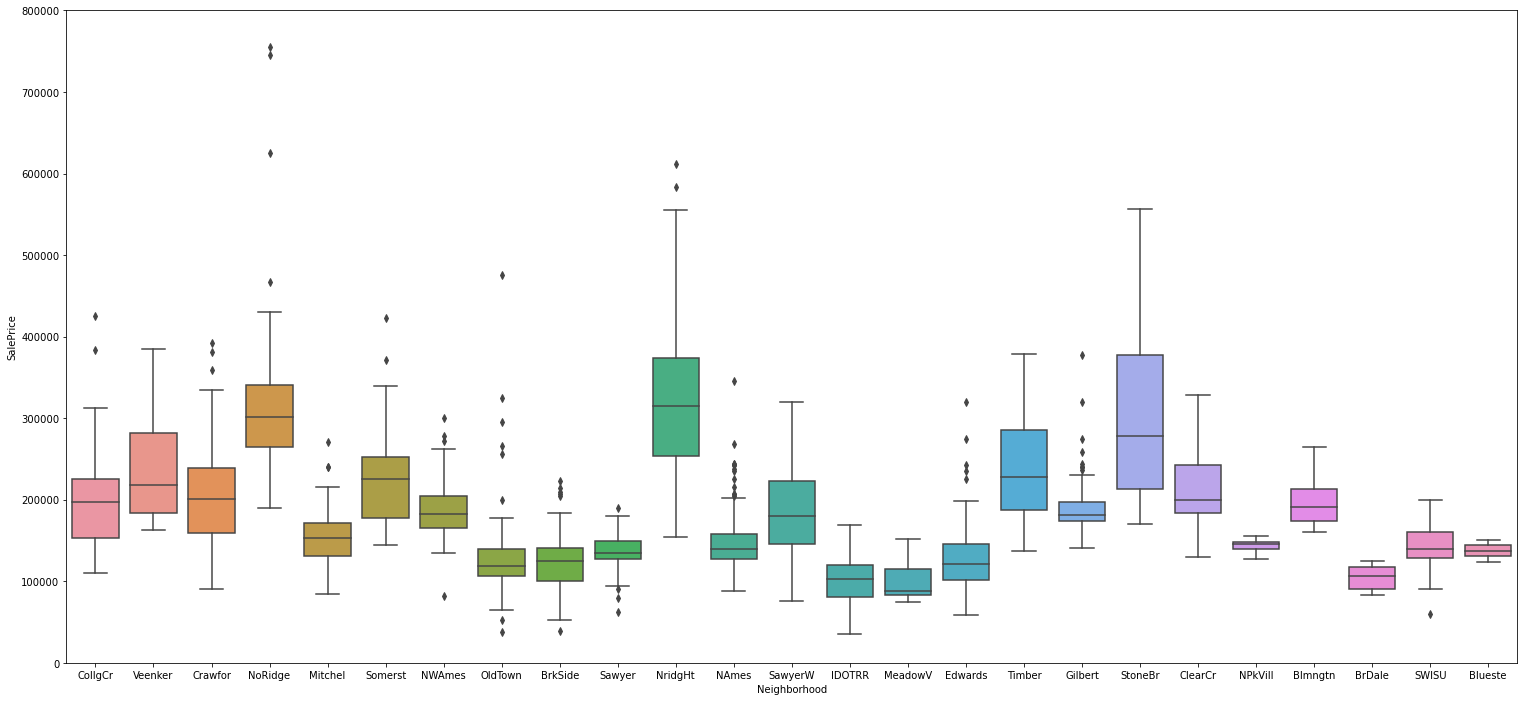

In [11]:
# Neighborhood
var = 'Neighborhood'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

地段不同，房价不同（该地区的经济，交通，人流量。。。）

In [12]:
location = []
for x in data['Neighborhood']:
    if x not in location:
        location.append(x)
data.sort_values(['Neighborhood','SalePrice'])
nb_data = data
nb_data

,SalePrice,Neighborhood
0,208500,CollgCr
1,181500,Veenker
2,223500,CollgCr
3,140000,Crawfor
4,250000,NoRidge
...,...,...
1455,175000,Gilbert
1456,210000,NWAmes
1457,266500,Crawfor
1458,142125,NAmes


### 3.2 数值型特征
#### 1.LotArea	地表面积

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

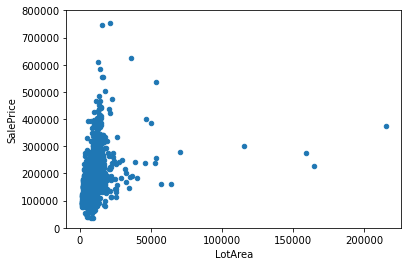

In [13]:
var  = 'LotArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

好像该特征并没有什么差别，所以不予考虑。

#### 2.GrLivArea	

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

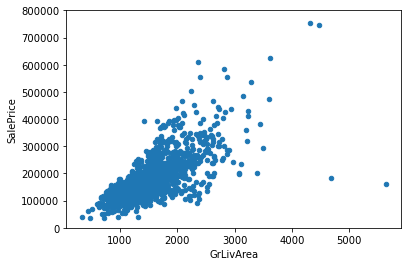

In [14]:
var  = 'GrLivArea'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

#### 3.TotalBsmtSF	

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

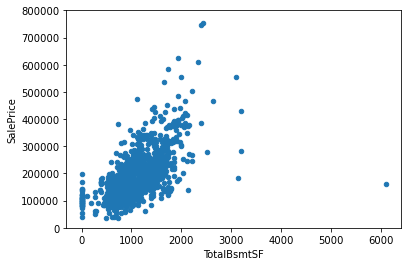

In [15]:
var  = 'TotalBsmtSF'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

房价与地下室面积呈现线性趋势，所以可以考虑。

#### 4.MiscVal	


<AxesSubplot:xlabel='MiscVal', ylabel='SalePrice'>

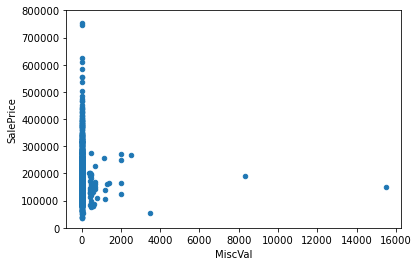

In [16]:
var  = 'MiscVal'
data = pd.concat([data_train['SalePrice'], data_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

如图，附加值对售价没什么很大英雄，不予考虑。

#### 5.GarageArea/GarageCars

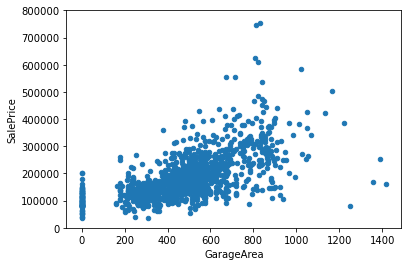

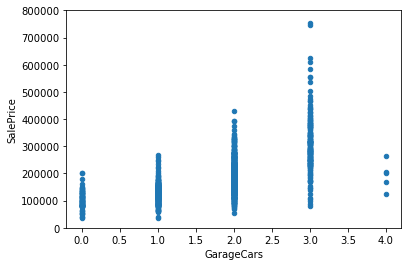

In [17]:
var  = ['GarageArea', 'GarageCars']
for index in range(2):
    data = pd.concat([data_train['SalePrice'], data_train[var[index]]], axis=1)
    data.plot.scatter(x=var[index], y='SalePrice', ylim=(0, 800000))

由上面点图可以看出房价与车库面积和容纳车辆数呈现线性关系，所以入选主要特征。

## 4. 主要特征
总结起来，最后

|Variable|Segment|Data Type|Comments|
|-------|--------|--------|---------|
|**GrLivArea**   | 1  |  0 |生活面积|
|**TotalBsmtSF**   | 1  |  0 |地下室总面积|
|**GarageArea**/**GarageCars** | 1  |  0 |车库|
|**YearBuilt**   | 0  | 1  | 建造年份|
|**CentralAir**   | 0  |  1 |中央空调|
|**OverallQual**   | 0  | 1  |总体评价|
|**Neighborhood**  |  2 |  1 |地段|

# 三、更加科学的分析数据

上面的分析可以说非常主观，所以说多多少少还是会不放心，会担心自己选择的特征会不会多了或者少了，又或者选了一些没有太大作用的特征，所以接下来需要进行更加科学的分析。

为了做到更加科学，我们需要作如下工作：
- 得到各个特征之间的关系矩阵（**correlation matrix**）
- 'SalePrice'的关系矩阵
- 绘制出最相关的特征之间的关系图

## 3.1 关系矩阵

<AxesSubplot:>

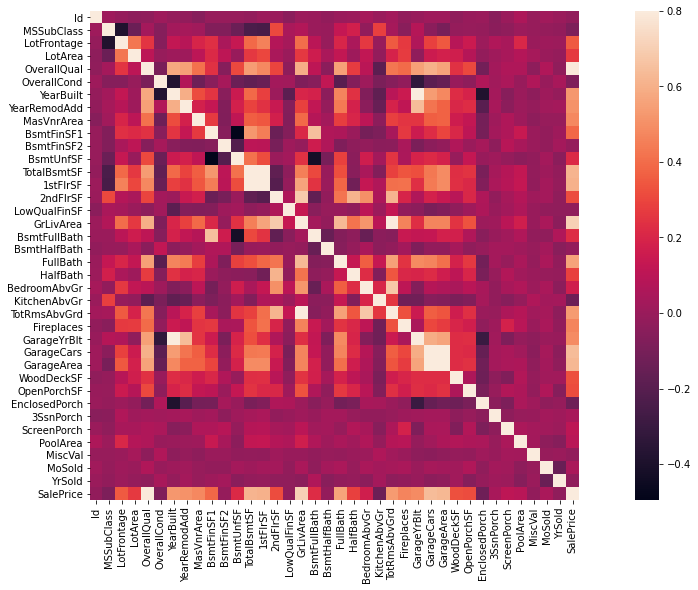

In [18]:
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

我们可以由图直到，像素块越红表示两者之间相关性越强，我们可以很清楚地看到与“**SalePrice**”相关性很强的有：
- **OverallQual**：总评价
- **YearBuilt**：建造年份
- **ToatlBsmtSF**：地下室面积
- **1stFlrSF**：一楼面积
- **GrLiveArea**：生活区面积？
- **FullBath**：浴室？what。。。到底什么意思，知道的麻烦说一下
- **TotRmsAbvGrd**：总房间数（不包括浴室）
- **GarageCars**：车库可容纳车辆数
- **GarageArea**：车库面积

看来之前我主观意见选择的特征和这相关矩阵显示的还是挺接近的，23333~~~

- 需要注意的是上面选取的特征也都是我靠肉眼判断颜色深浅选择的，所以还不是非常科学，后面会更加科学，尽情期待。

- 还需要注意的是上面的特征中有好几个是类似的，例如**GarageCars**和**GarageArea**，**ToatlBsmtSF**和**1stFlrSF**，至于怎么取舍看下面的分析。

- 最后突然发现上面的矩阵只是数值型的，像**Neighborhood**这种离散型数据则没有参与计算，所以下面尝试着使用sklearn来对这些特征进行处理。

<AxesSubplot:>

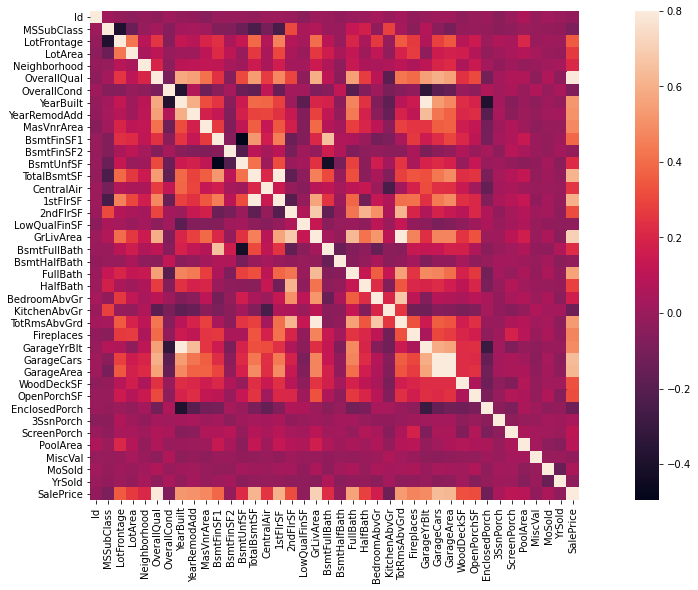

In [19]:
from sklearn import preprocessing
f_names = ['CentralAir', 'Neighborhood']
for x in f_names:
    label = preprocessing.LabelEncoder()
    data_train[x] = label.fit_transform(data_train[x])
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, square=True)

由上图可以看到'CentralAir', 'Neighborhood'这两个特征对房价的影响并不大，所以后面将不予考虑。

## 3.2 房价关系矩阵

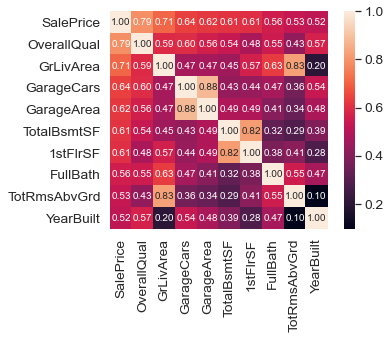

In [20]:
k  = 10 # 关系矩阵中将显示10个特征
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

由上图可以看出
- ‘OverallQual’，‘GrLiveArea’相关性非常强，与我们的预期一致，所以果断入选判断标准。

- 'GarageCars'和'GarageArea'也都双双进入关系户行列，但是我们知道，这两者留一个就够了，所以选择后台更硬的'GarageCars'。（这里，在最前的主观分析中我选择了这两个特征）

- 接下来是‘TotalBsmSF’和'1stFlrSF'，同理，这二者也类似，所以我们选择‘TotalBsmSF’（'1stFlrSF（一楼面积）'相关性居然这么强？求二楼面积的心理阴影）

- 'FullBath'这个特征其实我都不知道什么意思。。。，反正听科学的就行。

- 'TotRmsAbvGrd'和'GrLiveArea'这二者也类似。。。但是要我个人说我是希望这两个特征都留下，因为感觉并不是很冲突，给我的感觉面积越大，而且房间数量适当的多我会更喜欢，当然个人觉得房价也会越高。

- ‘YearBuilt’，这个东西在中国还是挺适合的。。。房价只会越来越贵，不知道什么时候会降价，或者说不再涨价。。。

最终我们需要考虑的特征值如下：


|Variable|Segment|Data Type|Comments|
|-------|--------|--------|---------|
|**GrLivArea**   | 1  |  0 |生活面积|
|**TotRmsAbvGrd**|1 |0|总房间数|
|**FullBath**|1|0|浴室数量|
|**TotalBsmtSF**   | 1  |  0 |地下室总面积|
|**GarageCars** | 1  |  0 |车库|
|**YearBuilt**   | 0  | 1  | 建造年份|
|**OverallQual**   | 0  | 1  |总体评价|

## 3.3 绘制关系点图

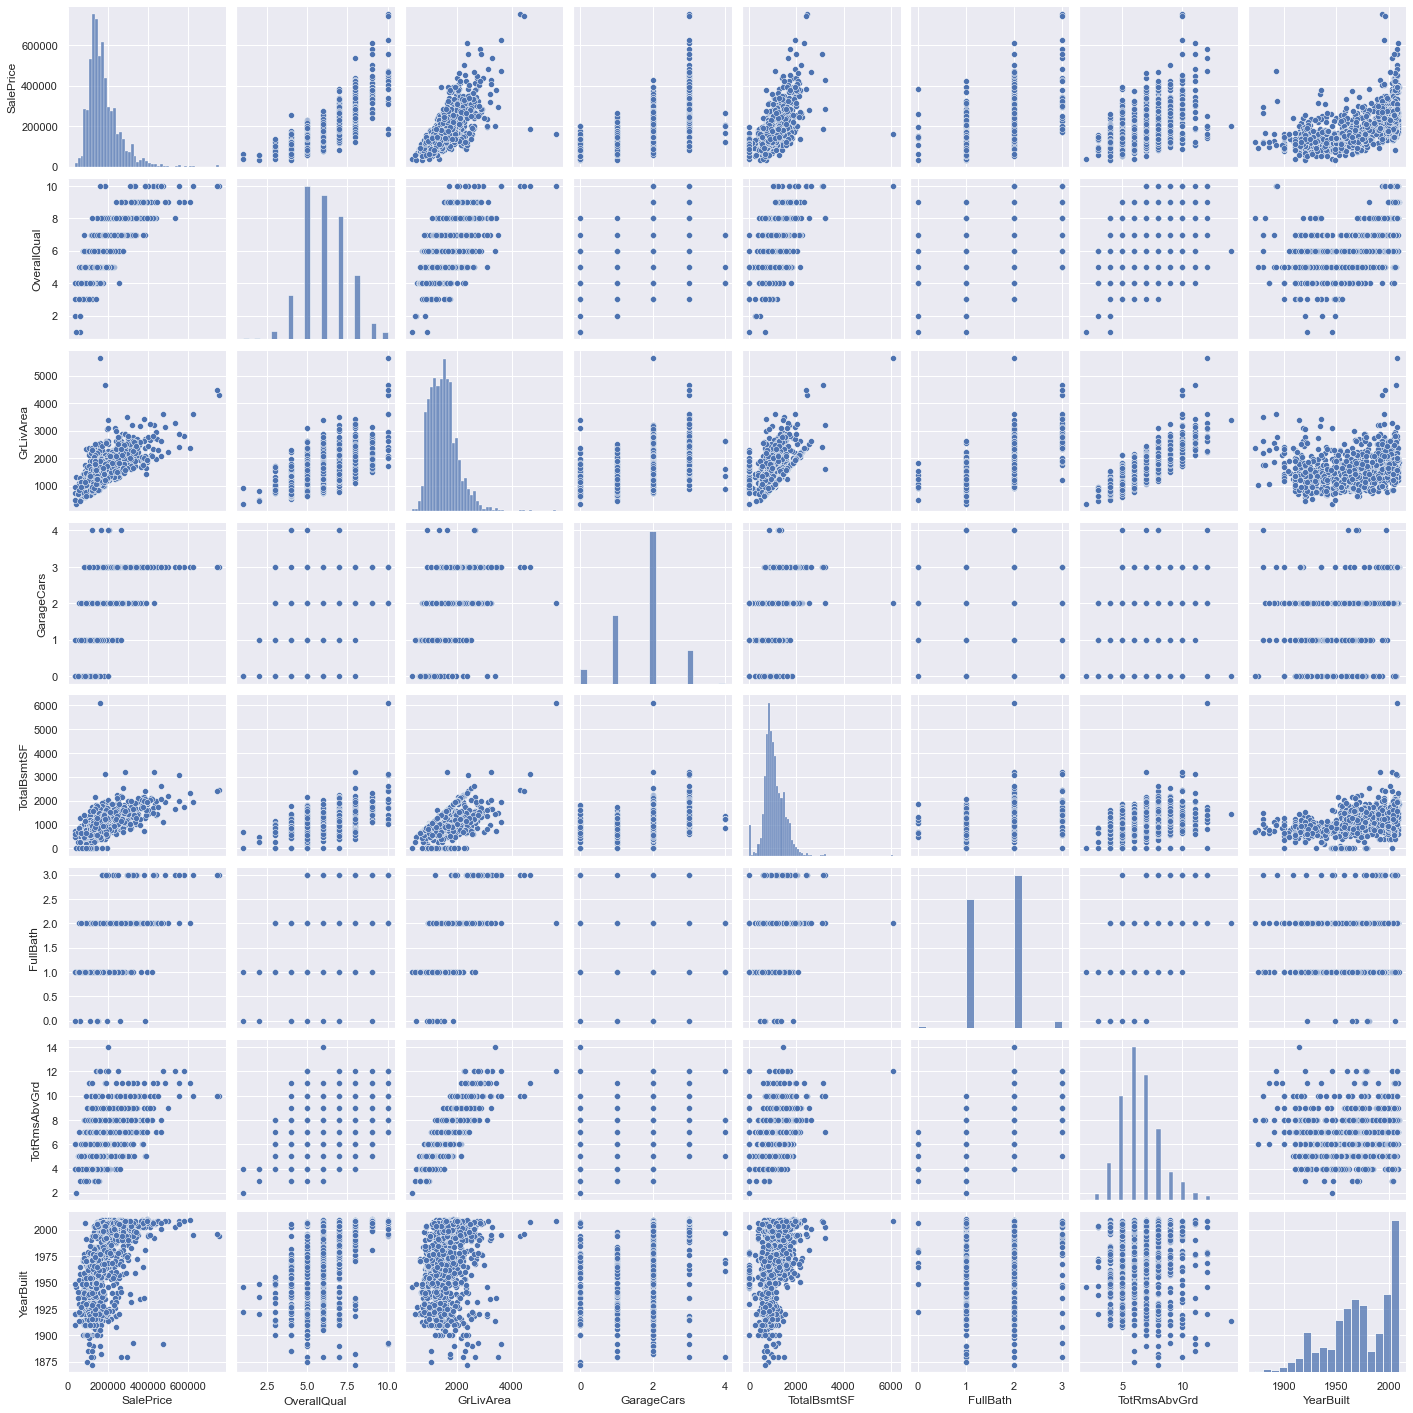

In [21]:
sns.set()
cols = ['SalePrice','OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(data_train[cols], size = 2.5)
plt.show()

# 四、开始预测数据

In [22]:
from sklearn import preprocessing
from sklearn import linear_model, svm, gaussian_process    #回归，SVM
from sklearn.ensemble import RandomForestRegressor        #随机森林
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import KFold             #KFold 普通K折交叉验证(数据划分)
from sklearn.model_selection import train_test_split   #分割数据集与训练集
# from sklearn.cross_validation import train_test_split
import numpy as np
from sklearn import metrics

## 获取数据
数据获取并进行标准化，然后数据划分

In [23]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
x = data_train[cols].values
y = data_train['SalePrice'].values
x_scaled = preprocessing.StandardScaler().fit_transform(x)  #标准化
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))
X_train,X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)## x_scaled：所要划分的样本特征集
                                                                                                       # y_scaled：所要划分的样本结果
                                                                                           #  test_size：样本占比，如果是整数的话就是样本的数量
                                                                                                       # random_state：是随机数的种子。

## 训练模型
一旦我们拥有独立的培训和测试集，我们就可以使用fit方法学习机器学习模型。 我们将使用score方法来测试此方法，依赖于默认的准确度指标，采用MSE、MAE、R2参数来进行衡量。

BayesianRidge cost:-3554.818389009116
svm cost:-13841.652963698658
RandomForestRegressor cost:-362.6829833863341


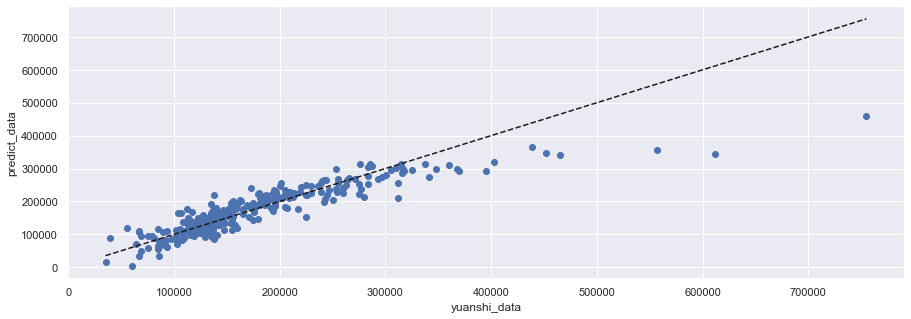

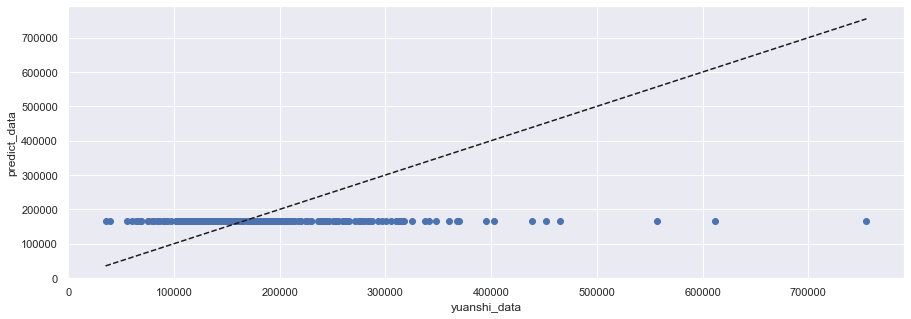

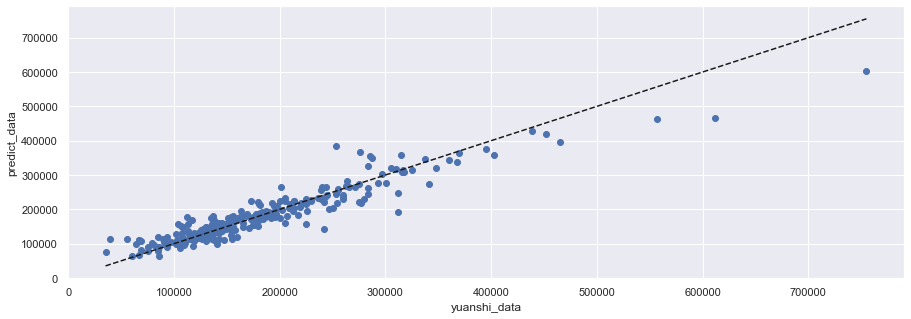

In [44]:
clfs = {                                                                 # 创建分类器对象
#         'LinearRegression':linear_model.LinearRegression(),                    #最小二乘回归（OLS）
        'BayesianRidge':linear_model.BayesianRidge(),                           #贝叶斯回归
        'svm':svm.SVR(),                                                       #SVM
        'RandomForestRegressor':RandomForestRegressor(n_estimators=400)       #随机森林
        
#         'DecisionTreeClassifier':tree.DecisionTreeClassifier()
#         'KMeans':KMeans(),
       }
for clf in clfs:
    try:
        clfs[clf].fit(X_train, y_train)             #用训练数据拟合分类器模型
        y_pred = clfs[clf].predict(X_test)         #＃ 用训练好的分类器去预测X_test数据
        print(clf + " cost:" + str(np.sum(y_pred-y_test)/len(y_pred)) ) 
        
        # 准确度
        accuracy = clfs[clf].score(X_test, y_test)
        print('{} Accuracy {:.2f}'.format(clf, accuracy))
        
        #均方差
        mse = mean_squared_error(y_test, y_pred)
        print("{} MSE :".format(clf)+"%.4f" % mse)    
        
        #平均绝对误差
        mae = metrics.mean_absolute_error(y_test, y_pred)
        print("{} MAE :".format(clf)+"%.4f" % mae)
        
        #R平方值
        R2 = metrics.r2_score(y_test,y_pred)
        print("{} R2 :".format(clf)+"%.4f" % R2)
        
#         plt.figure(figsize=(15,5))
#         plt.plot(range(len(y_test)), y_test, 'r', label='test_data')
#         plt.plot(range(len(y_test)), y_pred, 'b', label='predict_data')
#         plt.legend()
        
        plt.figure(figsize=(15,5))
        plt.scatter(y_test, y_pred)
        plt.plot([y_test.min(),y_test.max()], [y_test.min(),y_test.max()], 'k--')
        plt.xlabel('yuanshi_data')
        plt.ylabel('predict_data')
    
        
    except Exception as e:
        print(clf + " Error:")
        print(str(e))

In [25]:
#无用（例子）
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import classification_report
# y_true = [0, 1, 2, 2, 2]
# y_pred = [0, 0, 2, 2, 1]
# target_names = ['class 0', 'class 1', 'class 2']
# print(classification_report(y_true, y_pred, target_names=target_names))
# # accuracy_score(y_true, y_pred)

In [26]:
#**************************************************没调试出来****************************************************
#调用sklearn库中的指标求解
# from sklearn.metrics import accuracy_score   
# from sklearn.metrics import precision_recall_curve 
# from sklearn.metrics import average_precision_score 
# from sklearn.metrics import classification_report

# #给出分类结果y_pred = [0, 1, 0, 0]

# # y_true = [0, 1, 1, 1]
# for clf in clfs:
#     clfs[clf].fit(X_train, y_train)
#     print("accuracy_score:", clfs[clf].accuracy_score(y_true, y_pred))
#     print("precision_score:", clfs[clf].metrics.precision_score(y_true, y_pred))
#     print("recall_score:", clfs[clf].metrics.recall_score(y_true, y_pred))
#     print("f1_score:", clfs[clf].metrics.f1_score(y_true, y_pred))
#     print("f0.5_score:", clfs[clf].metrics.fbeta_score(y_true, y_pred, beta=0.5))
#     print("f2_score:", clfs[clf].metrics.fbeta_score(y_true, y_pred, beta=2.0))

## 选择最优算法对未知数据进行预测
由上面结果选择随机森林回归算法，为了更直观地观察训练结果，我将显示一下未归一化数据的预测效果。

In [27]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
x = data_train[cols].values
y = data_train['SalePrice'].values
X_train,X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

clf = RandomForestRegressor(n_estimators=400)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)

# 保存clf，共下面计算测试集数据使用
# rfr = clf

[141175.         308508.8425     112763.9375     173112.25
 311355.78        79766.91666667 191933.75       151696.6
  79761.57142857 119018.26       162614.475      107965.68738095
  95564.75       222212.4675     191093.5        126334.25
 193235.5        133235.25       113286.3125     196171.725
 160503.875      212934.83333333 171414.14083333 122159.19166667
 185232.7        171269.6        211531.35        98255.8725
 186950.75       202562.69333333 112417.75       242136.11
 175083.75       111532.25       259479.455      138206.625
 168897.31       205945.905      313270.3475     104721.25
 130847.         232766.815      116611.09583333 378527.0075
 137139.9        167141.5475     124021.14       121634.
 419362.525      145106.765      122493.68583333 185747.5
 125476.31341667 351454.8675     143810.83144841 244044.09
 196916.29166667 154165.6475     152497.8375     101766.75
  81851.125      139805.9375     316774.795      280229.5
 265980.5425     234526.205      109206.957

In [28]:
y_test

array([154500, 325000, 115000, 159000, 315500,  75500, 311500, 146000,
        84500, 135500, 145000, 130000,  81000, 214000, 181000, 134500,
       183500, 135000, 118400, 226000, 155000, 210000, 173500, 129000,
       192000, 153900, 181134, 141000, 181000, 208900, 127000, 284000,
       200500, 135750, 255000, 140000, 138000, 219500, 310000,  97000,
       114500, 205000, 119500, 253293, 128500, 117500, 115000, 127000,
       451950, 144000, 119000, 196000, 115000, 287000, 144500, 260000,
       213000, 175000, 107000, 107500,  68500, 154000, 317000, 264132,
       283463, 243000, 109000, 305000,  93500, 176000, 118858, 134000,
       109008,  93500, 611657, 173000, 348000, 341000, 141000, 124900,
       118000,  67000, 113000,  91300, 149500, 133000, 266000, 190000,
       155900, 155835, 153500, 152000, 124500, 301000, 136500, 169990,
       205000, 183900, 204900, 260000, 163500, 224900, 244000, 132000,
       194000, 156500, 156000, 275000, 145000, 135000,  60000, 124000,
      

In [29]:
sum(abs(y_pred - y_test))/len(y_pred)

18961.049297483132

# 五、检验测试集数据

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# 之前训练的模型
rfr = clf

In [31]:
data_test = pd.read_csv("test.csv")

```python
data_test = pd.read_csv("./test.csv")
data_test[cols].isnull().sum()
```

>OverallQual 0
GrLivArea       0

>GarageCars      1

>TotalBsmtSF     1

>FullBath        0

>TotRmsAbvGrd    0

>YearBuilt       0

>dtype: int64

因为数据中存在缺失值，所以不能直接predict，而且缺失值较少，所以我直接在excel文件中将缺失值改为了该列的均值。所以需要先算出平均值。

In [32]:
data_test[cols].isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      1
TotalBsmtSF     1
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
dtype: int64

In [33]:
data_test['GarageCars'].describe()

count    1458.000000
mean        1.766118
std         0.775945
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: GarageCars, dtype: float64

In [34]:
data_test['TotalBsmtSF'].describe()

count    1458.000000
mean     1046.117970
std       442.898624
min         0.000000
25%       784.000000
50%       988.000000
75%      1305.000000
max      5095.000000
Name: TotalBsmtSF, dtype: float64

In [35]:
# 不知道为什么fillna函数对data_test[cols]总是不起作用，所以只好用最笨的办法了
#data_test[ ['GarageCars'] ].fillna(1.766118, inplace=True)
#data_test[ ['TotalBsmtSF']].fillna(1046.117970, inplace=True) 
#data_test[cols].fillna(data_test[cols].mean())
#data_test[cols].isnull().sum()

cols2 = ['OverallQual','GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
cars = data_test['GarageCars'].fillna(1.766118)
bsmt = data_test['TotalBsmtSF'].fillna(1046.117970)
data_test_x = pd.concat( [data_test[cols2], cars, bsmt] ,axis=1)
data_test_x.isnull().sum()

OverallQual     0
GrLivArea       0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
GarageCars      0
TotalBsmtSF     0
dtype: int64

In [36]:
x = data_test_x.values
y_te_pred = rfr.predict(x)
print(y_te_pred)

print(y_te_pred.shape)
print(x.shape)

[ 94782.135   107175.03625 129765.655   ... 103558.30125  94545.01
 175720.925  ]
(1459,)
(1459, 7)


In [37]:
data_test_x

,OverallQual,GrLivArea,FullBath,TotRmsAbvGrd,YearBuilt,GarageCars,TotalBsmtSF
0,5,896,1,5,1961,1.0,882.0
1,6,1329,1,6,1958,1.0,1329.0
2,5,1629,2,6,1997,2.0,928.0
3,6,1604,2,7,1998,2.0,926.0
4,8,1280,2,5,1992,2.0,1280.0
...,...,...,...,...,...,...,...
1454,4,1092,1,5,1970,0.0,546.0
1455,4,1092,1,6,1970,1.0,546.0
1456,5,1224,1,7,1960,2.0,1224.0
1457,5,970,1,6,1992,0.0,912.0


In [38]:
prediction = pd.DataFrame(y_te_pred, columns=['SalePrice'])
result = pd.concat([ data_test['Id'], prediction], axis=1)
# result = result.drop(resultlt.columns[0], 1)
result.columns

Index(['Id', 'SalePrice'], dtype='object')

In [39]:
# 保存预测结果
result.to_csv('./Predictions.csv', index=False)